In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 322
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=50

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

# METHOD = "IR" # identical_random
# METHOD = "DR" # different_random

DATASET_DIR_NAME = "dataset\set02\\01_original"
SAMPLE_DATASET_NAME = "train"
# ACTUAL_DATASET_NAME = "test"

MODEL_DIR_NAME = "dataset\set02\\01_original"
MODEL_NAME = "model_" + "set02_01_original"

# RESULT_DIR_NAME = "dataset\set02\\01_original"
# RESULT_NAME = "result_" + "set02_01_original"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
# ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

# RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
# RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\01_original
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\01_original
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\01_original\train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9
0,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.386410,0.138486,0.300717,...,0.002393,0.001434,0.037765,0.026706,0.048922,0.037863,1.804767,1.958893,1.936692,2.090818
1,adhy,4,heat atoms,0.185183,0.253542,0.438725,0.385330,0.570513,0.131788,0.285710,...,0.057276,0.076773,0.190323,0.228078,0.239324,0.277080,1.389586,1.574769,1.505635,1.690818
2,adhy,5,chant axis,0.147403,-0.069143,0.078260,0.068697,0.216100,0.137840,0.015532,...,0.005058,0.004142,0.093102,0.086340,0.071119,0.064357,1.256483,1.403886,1.372666,1.520069
3,adhy,6,oldies bay,0.116146,0.185094,0.301241,0.347630,0.463776,0.162536,0.037921,...,0.030531,0.020144,0.126528,0.093725,0.174730,0.141928,1.488371,1.604517,1.604610,1.720756
4,adhy,3,gym zygote,0.137315,-0.084266,0.053049,0.015728,0.153044,0.099994,0.169676,...,0.002392,0.000507,0.048903,0.022514,0.048912,0.022522,1.188967,1.326283,1.320779,1.458094


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


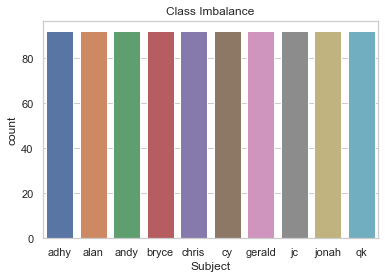

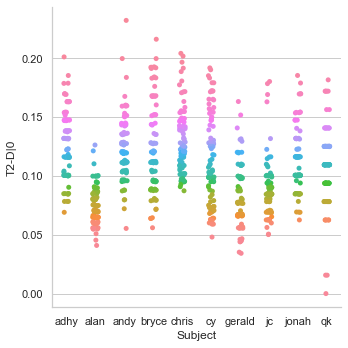

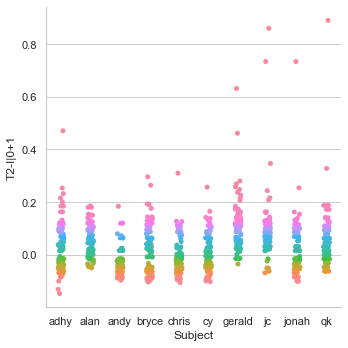

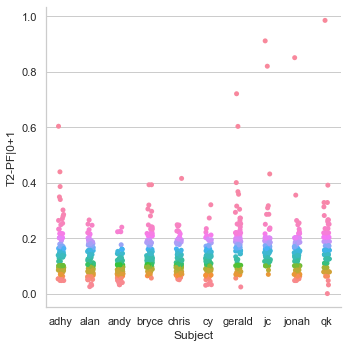

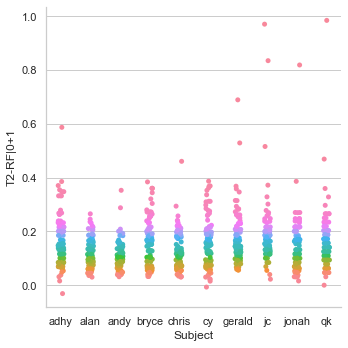

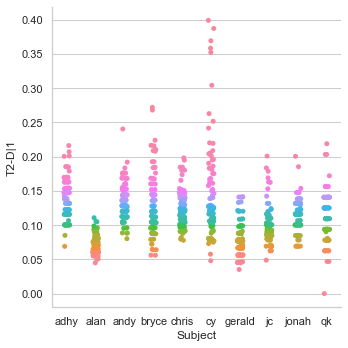

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (920, 322)
Y | Classes  | Dataset Shape: (920, 10)
Number of Classes: 10


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (736, 1, 322)
Y train shape: (736, 10)
X test shape: (184, 1, 322)
Y test shape: (184, 10)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 10 classes.
Epoch 1/400
12/12 [==============================] - 6s 14ms/step - loss: 2.5321 - accuracy: 0.1003
Epoch 2/400
12/12 [==============================] - 0s 12ms/step - loss: 2.4692 - accuracy: 0.1003
Epoch 3/400
12/12 [==============================] - 0s 12ms/step - loss: 2.4339 - accuracy: 0.0901
Epoch 4/400
12/12 [==============================] - 0s 12ms/step - loss: 2.3669 - accuracy: 0.0986
Epoch 5/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3697 - accuracy: 0.1122
Epoch 6/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3617 - accuracy: 0.1173
Epoch 7/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3347 - accuracy: 0.1224
Epoch 8/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3425 - accuracy: 0.1139
Epoch 9/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3211 - accuracy: 0.1344
Epoch 10/400
12/12 [==============================] - 0s 15ms/step 

12/12 [==============================] - 0s 13ms/step - loss: 1.5082 - accuracy: 0.3946
Epoch 82/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5189 - accuracy: 0.3810
Epoch 83/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5086 - accuracy: 0.4133
Epoch 84/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5172 - accuracy: 0.3980
Epoch 85/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5265 - accuracy: 0.3929
Epoch 86/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4744 - accuracy: 0.3946
Epoch 87/400
12/12 [==============================] - 0s 14ms/step - loss: 1.4592 - accuracy: 0.4320
Epoch 88/400
12/12 [==============================] - 0s 14ms/step - loss: 1.4974 - accuracy: 0.4099
Epoch 89/400
12/12 [==============================] - 0s 14ms/step - loss: 1.4990 - accuracy: 0.4269
Epoch 90/400
12/12 [==============================] - 0s 14ms/step - loss: 1.4702 - accuracy: 0.4184
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.3793 - accuracy: 0.4643
Epoch 162/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3807 - accuracy: 0.4473
Epoch 163/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3552 - accuracy: 0.4473
Epoch 164/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3854 - accuracy: 0.4490
Epoch 165/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3479 - accuracy: 0.4745
Epoch 166/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3396 - accuracy: 0.4711
Epoch 167/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3417 - accuracy: 0.4660
Epoch 168/400
12/12 [==============================] - 0s 12ms/step - loss: 1.2967 - accuracy: 0.4830
Epoch 169/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3156 - accuracy: 0.4830
Epoch 170/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3382 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.2395 - accuracy: 0.5136
Epoch 242/400
12/12 [==============================] - 0s 14ms/step - loss: 1.2899 - accuracy: 0.4932
Epoch 243/400
12/12 [==============================] - 0s 15ms/step - loss: 1.2407 - accuracy: 0.5017
Epoch 244/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2560 - accuracy: 0.5034
Epoch 245/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2845 - accuracy: 0.4881
Epoch 246/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3548 - accuracy: 0.4541
Epoch 247/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3135 - accuracy: 0.4745
Epoch 248/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2357 - accuracy: 0.5000
Epoch 249/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3041 - accuracy: 0.5051
Epoch 250/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3009 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.1831 - accuracy: 0.5510
Epoch 322/400
12/12 [==============================] - 0s 14ms/step - loss: 1.1504 - accuracy: 0.5646
Epoch 323/400
12/12 [==============================] - 0s 14ms/step - loss: 1.1603 - accuracy: 0.5306
Epoch 324/400
12/12 [==============================] - 0s 14ms/step - loss: 1.1395 - accuracy: 0.5561
Epoch 325/400
12/12 [==============================] - 0s 14ms/step - loss: 1.1331 - accuracy: 0.5850
Epoch 326/400
12/12 [==============================] - 0s 14ms/step - loss: 1.1722 - accuracy: 0.5544
Epoch 327/400
12/12 [==============================] - 0s 13ms/step - loss: 1.1489 - accuracy: 0.5697
Epoch 328/400
12/12 [==============================] - 0s 13ms/step - loss: 1.1632 - accuracy: 0.5187
Epoch 329/400
12/12 [==============================] - 0s 14ms/step - loss: 1.2088 - accuracy: 0.5408
Epoch 330/400
12/12 [==============================] - 0s 13ms/step - loss: 1.1282 - accuracy: 0

3/3 [==============================] - 1s 5ms/step - loss: 2.3771 - accuracy: 0.2838
There are a total of 10 classes.
Epoch 1/400
12/12 [==============================] - 7s 13ms/step - loss: 2.5085 - accuracy: 0.1171
Epoch 2/400
12/12 [==============================] - 0s 13ms/step - loss: 2.4614 - accuracy: 0.1019
Epoch 3/400
12/12 [==============================] - 0s 14ms/step - loss: 2.4238 - accuracy: 0.0832
Epoch 4/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3873 - accuracy: 0.1121
Epoch 5/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3867 - accuracy: 0.0900
Epoch 6/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3384 - accuracy: 0.1171
Epoch 7/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3363 - accuracy: 0.1087
Epoch 8/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3521 - accuracy: 0.0713
Epoch 9/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3271 -

12/12 [==============================] - 0s 13ms/step - loss: 1.6180 - accuracy: 0.3158
Epoch 82/400
12/12 [==============================] - 0s 12ms/step - loss: 1.6010 - accuracy: 0.3514
Epoch 83/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6333 - accuracy: 0.3345
Epoch 84/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6400 - accuracy: 0.3328
Epoch 85/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6441 - accuracy: 0.3599
Epoch 86/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5946 - accuracy: 0.3684
Epoch 87/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6027 - accuracy: 0.3616
Epoch 88/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6324 - accuracy: 0.3141
Epoch 89/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6014 - accuracy: 0.3480
Epoch 90/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6039 - accuracy: 0.3396
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.4500 - accuracy: 0.3922
Epoch 162/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4916 - accuracy: 0.4109
Epoch 163/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4766 - accuracy: 0.4278
Epoch 164/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4503 - accuracy: 0.4228
Epoch 165/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4534 - accuracy: 0.4143
Epoch 166/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4555 - accuracy: 0.4244
Epoch 167/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4987 - accuracy: 0.4075
Epoch 168/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4618 - accuracy: 0.4244
Epoch 169/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4416 - accuracy: 0.4380
Epoch 170/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5117 - accuracy: 0

12/12 [==============================] - 0s 13ms/step - loss: 1.3286 - accuracy: 0.4601
Epoch 242/400
12/12 [==============================] - 0s 12ms/step - loss: 1.2742 - accuracy: 0.4958
Epoch 243/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3216 - accuracy: 0.4635
Epoch 244/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3691 - accuracy: 0.4618
Epoch 245/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3375 - accuracy: 0.4550
Epoch 246/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3528 - accuracy: 0.4669
Epoch 247/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3724 - accuracy: 0.4465
Epoch 248/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3737 - accuracy: 0.4737
Epoch 249/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3047 - accuracy: 0.4788
Epoch 250/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2870 - accuracy: 0

12/12 [==============================] - 0s 13ms/step - loss: 1.2435 - accuracy: 0.5331
Epoch 322/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2284 - accuracy: 0.5161
Epoch 323/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2290 - accuracy: 0.5263
Epoch 324/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2532 - accuracy: 0.5161
Epoch 325/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2611 - accuracy: 0.5382
Epoch 326/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2608 - accuracy: 0.5008
Epoch 327/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4126 - accuracy: 0.4635
Epoch 328/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2722 - accuracy: 0.5365
Epoch 329/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2513 - accuracy: 0.5280
Epoch 330/400
12/12 [==============================] - 0s 12ms/step - loss: 1.2151 - accuracy: 0

3/3 [==============================] - 1s 6ms/step - loss: 1.5562 - accuracy: 0.4218
There are a total of 10 classes.
Epoch 1/400
12/12 [==============================] - 5s 14ms/step - loss: 2.4829 - accuracy: 0.1019
Epoch 2/400
12/12 [==============================] - 0s 12ms/step - loss: 2.4042 - accuracy: 0.1121
Epoch 3/400
12/12 [==============================] - 0s 11ms/step - loss: 2.3711 - accuracy: 0.1154
Epoch 4/400
12/12 [==============================] - 0s 11ms/step - loss: 2.3731 - accuracy: 0.1019
Epoch 5/400
12/12 [==============================] - 0s 11ms/step - loss: 2.3722 - accuracy: 0.0968
Epoch 6/400
12/12 [==============================] - 0s 12ms/step - loss: 2.3349 - accuracy: 0.1019
Epoch 7/400
12/12 [==============================] - 0s 12ms/step - loss: 2.3491 - accuracy: 0.1087
Epoch 8/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3294 - accuracy: 0.1036
Epoch 9/400
12/12 [==============================] - 0s 13ms/step - loss: 2.2720 -

12/12 [==============================] - 0s 13ms/step - loss: 1.5639 - accuracy: 0.3463
Epoch 82/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5733 - accuracy: 0.3735
Epoch 83/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5983 - accuracy: 0.3463
Epoch 84/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5615 - accuracy: 0.3480
Epoch 85/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5820 - accuracy: 0.3582
Epoch 86/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5475 - accuracy: 0.3786
Epoch 87/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5176 - accuracy: 0.4075
Epoch 88/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5641 - accuracy: 0.3667
Epoch 89/400
12/12 [==============================] - 0s 12ms/step - loss: 1.5504 - accuracy: 0.3803
Epoch 90/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5144 - accuracy: 0.3599
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.4485 - accuracy: 0.4041
Epoch 162/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4258 - accuracy: 0.4075
Epoch 163/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4332 - accuracy: 0.4126
Epoch 164/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4298 - accuracy: 0.4075
Epoch 165/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4298 - accuracy: 0.4109
Epoch 166/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4169 - accuracy: 0.4160
Epoch 167/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3869 - accuracy: 0.4363
Epoch 168/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4926 - accuracy: 0.3769
Epoch 169/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4155 - accuracy: 0.4126
Epoch 170/400
12/12 [==============================] - 0s 12ms/step - loss: 1.4515 - accuracy: 0

12/12 [==============================] - 0s 12ms/step - loss: 1.2917 - accuracy: 0.4635
Epoch 242/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3273 - accuracy: 0.4601
Epoch 243/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3593 - accuracy: 0.4431
Epoch 244/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2552 - accuracy: 0.4924
Epoch 245/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3687 - accuracy: 0.4669
Epoch 246/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3116 - accuracy: 0.4771
Epoch 247/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3007 - accuracy: 0.4771
Epoch 248/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3025 - accuracy: 0.4686
Epoch 249/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3217 - accuracy: 0.4703
Epoch 250/400
12/12 [==============================] - 0s 12ms/step - loss: 1.3003 - accuracy: 0

12/12 [==============================] - 0s 13ms/step - loss: 1.3581 - accuracy: 0.4839
Epoch 322/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2897 - accuracy: 0.4499
Epoch 323/400
12/12 [==============================] - 0s 12ms/step - loss: 1.2655 - accuracy: 0.5008
Epoch 324/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2814 - accuracy: 0.4822
Epoch 325/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2622 - accuracy: 0.4924
Epoch 326/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2474 - accuracy: 0.5144
Epoch 327/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2308 - accuracy: 0.5076
Epoch 328/400
12/12 [==============================] - 0s 12ms/step - loss: 1.2214 - accuracy: 0.5314
Epoch 329/400
12/12 [==============================] - 0s 14ms/step - loss: 1.2523 - accuracy: 0.4924
Epoch 330/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2551 - accuracy: 0

3/3 [==============================] - 2s 6ms/step - loss: 1.7700 - accuracy: 0.3673
There are a total of 10 classes.
Epoch 1/400
12/12 [==============================] - 6s 14ms/step - loss: 2.5212 - accuracy: 0.0900
Epoch 2/400
12/12 [==============================] - 0s 13ms/step - loss: 2.4660 - accuracy: 0.1002
Epoch 3/400
12/12 [==============================] - 0s 12ms/step - loss: 2.4002 - accuracy: 0.1138
Epoch 4/400
12/12 [==============================] - 0s 12ms/step - loss: 2.3690 - accuracy: 0.0934
Epoch 5/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3641 - accuracy: 0.1036
Epoch 6/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3380 - accuracy: 0.1154
Epoch 7/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3300 - accuracy: 0.1036
Epoch 8/400
12/12 [==============================] - 0s 14ms/step - loss: 2.2976 - accuracy: 0.1460
Epoch 9/400
12/12 [==============================] - 0s 13ms/step - loss: 2.2773 -

12/12 [==============================] - 0s 13ms/step - loss: 1.6491 - accuracy: 0.3294
Epoch 82/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6261 - accuracy: 0.3430
Epoch 83/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6228 - accuracy: 0.3141
Epoch 84/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6027 - accuracy: 0.3548
Epoch 85/400
12/12 [==============================] - 0s 13ms/step - loss: 1.6294 - accuracy: 0.3514
Epoch 86/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5769 - accuracy: 0.3718
Epoch 87/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5959 - accuracy: 0.3684
Epoch 88/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5735 - accuracy: 0.3447
Epoch 89/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5980 - accuracy: 0.3463
Epoch 90/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5594 - accuracy: 0.3752
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.4731 - accuracy: 0.4041
Epoch 162/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4702 - accuracy: 0.4160
Epoch 163/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4307 - accuracy: 0.4380
Epoch 164/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4561 - accuracy: 0.4244
Epoch 165/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4834 - accuracy: 0.4211
Epoch 166/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4317 - accuracy: 0.4228
Epoch 167/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4449 - accuracy: 0.4177
Epoch 168/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4265 - accuracy: 0.4329
Epoch 169/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4496 - accuracy: 0.4058
Epoch 170/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4345 - accuracy: 0

12/12 [==============================] - 0s 13ms/step - loss: 1.3724 - accuracy: 0.4635
Epoch 242/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3239 - accuracy: 0.4601
Epoch 243/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3432 - accuracy: 0.4482
Epoch 244/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3726 - accuracy: 0.4363
Epoch 245/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3201 - accuracy: 0.4703
Epoch 246/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3195 - accuracy: 0.4584
Epoch 247/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3421 - accuracy: 0.4635
Epoch 248/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3399 - accuracy: 0.4499
Epoch 249/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3558 - accuracy: 0.4754
Epoch 250/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4040 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.3206 - accuracy: 0.4788
Epoch 322/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3171 - accuracy: 0.4431
Epoch 323/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3200 - accuracy: 0.4652
Epoch 324/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3101 - accuracy: 0.4652
Epoch 325/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3022 - accuracy: 0.4822
Epoch 326/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3058 - accuracy: 0.4754
Epoch 327/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3170 - accuracy: 0.4550
Epoch 328/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2776 - accuracy: 0.4975
Epoch 329/400
12/12 [==============================] - 0s 13ms/step - loss: 1.4004 - accuracy: 0.4601
Epoch 330/400
12/12 [==============================] - 0s 14ms/step - loss: 1.4745 - accuracy: 0

3/3 [==============================] - 2s 6ms/step - loss: 1.6829 - accuracy: 0.4014
There are a total of 10 classes.
Epoch 1/400
12/12 [==============================] - 6s 14ms/step - loss: 2.6648 - accuracy: 0.1036
Epoch 2/400
12/12 [==============================] - 0s 13ms/step - loss: 2.5726 - accuracy: 0.0883
Epoch 3/400
12/12 [==============================] - 0s 13ms/step - loss: 2.4819 - accuracy: 0.1053
Epoch 4/400
12/12 [==============================] - 0s 12ms/step - loss: 2.4391 - accuracy: 0.1154
Epoch 5/400
12/12 [==============================] - 0s 13ms/step - loss: 2.3987 - accuracy: 0.0832
Epoch 6/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3792 - accuracy: 0.1104
Epoch 7/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3600 - accuracy: 0.1036
Epoch 8/400
12/12 [==============================] - 0s 14ms/step - loss: 2.3334 - accuracy: 0.1019
Epoch 9/400
12/12 [==============================] - 0s 14ms/step - loss: 2.2969 -

12/12 [==============================] - 0s 13ms/step - loss: 1.5869 - accuracy: 0.3803
Epoch 82/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5011 - accuracy: 0.4041
Epoch 83/400
12/12 [==============================] - 0s 14ms/step - loss: 1.5666 - accuracy: 0.3820
Epoch 84/400
12/12 [==============================] - 0s 14ms/step - loss: 1.5371 - accuracy: 0.3701
Epoch 85/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5347 - accuracy: 0.3939
Epoch 86/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5153 - accuracy: 0.3990
Epoch 87/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5254 - accuracy: 0.3905
Epoch 88/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5383 - accuracy: 0.3752
Epoch 89/400
12/12 [==============================] - 0s 14ms/step - loss: 1.5084 - accuracy: 0.3939
Epoch 90/400
12/12 [==============================] - 0s 13ms/step - loss: 1.5533 - accuracy: 0.3871
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.3708 - accuracy: 0.4584
Epoch 162/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3879 - accuracy: 0.4431
Epoch 163/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3646 - accuracy: 0.4499
Epoch 164/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3763 - accuracy: 0.4499
Epoch 165/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3416 - accuracy: 0.4380
Epoch 166/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3637 - accuracy: 0.4380
Epoch 167/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3965 - accuracy: 0.4278
Epoch 168/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3382 - accuracy: 0.4601
Epoch 169/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3411 - accuracy: 0.4601
Epoch 170/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3544 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.3344 - accuracy: 0.4737
Epoch 242/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3234 - accuracy: 0.4686
Epoch 243/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3300 - accuracy: 0.4703
Epoch 244/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3381 - accuracy: 0.4839
Epoch 245/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3123 - accuracy: 0.4669
Epoch 246/400
12/12 [==============================] - 0s 15ms/step - loss: 1.3367 - accuracy: 0.4533
Epoch 247/400
12/12 [==============================] - 0s 15ms/step - loss: 1.3277 - accuracy: 0.4720
Epoch 248/400
12/12 [==============================] - 0s 14ms/step - loss: 1.2882 - accuracy: 0.4924
Epoch 249/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3026 - accuracy: 0.4686
Epoch 250/400
12/12 [==============================] - 0s 14ms/step - loss: 1.3523 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.2688 - accuracy: 0.5076
Epoch 322/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2620 - accuracy: 0.4907
Epoch 323/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2736 - accuracy: 0.5008
Epoch 324/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2448 - accuracy: 0.5093
Epoch 325/400
12/12 [==============================] - 0s 14ms/step - loss: 1.2511 - accuracy: 0.4924
Epoch 326/400
12/12 [==============================] - 0s 13ms/step - loss: 1.1955 - accuracy: 0.5484
Epoch 327/400
12/12 [==============================] - 0s 13ms/step - loss: 1.3038 - accuracy: 0.5042
Epoch 328/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2417 - accuracy: 0.4907
Epoch 329/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2509 - accuracy: 0.5059
Epoch 330/400
12/12 [==============================] - 0s 13ms/step - loss: 1.2446 - accuracy: 0

3/3 [==============================] - 1s 7ms/step - loss: 1.3560 - accuracy: 0.3946


##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 37.38% (with standard deviation of 4.82%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 10 classes.
Epoch 1/400
15/15 [==============================] - 6s 14ms/step - loss: 2.5237 - accuracy: 0.1114
Epoch 2/400
15/15 [==============================] - 0s 13ms/step - loss: 2.4431 - accuracy: 0.1060
Epoch 3/400
15/15 [==============================] - 0s 15ms/step - loss: 2.3978 - accuracy: 0.1060
Epoch 4/400
15/15 [==============================] - 0s 17ms/step - loss: 2.3552 - accuracy: 0.0992
Epoch 5/400
15/15 [==============================] - 0s 15ms/step - loss: 2.3378 - accuracy: 0.1019
Epoch 6/400
15/15 [==============================] - 0s 15ms/step - loss: 2.3495 - accuracy: 0.1155
Epoch 7/400
15/15 [==============================] - 0s 15ms/step - loss: 2.2891 - accuracy: 0.1318
Epoch 8/400
15/15 [==============================] - 0s 16ms/step - loss: 2.2536 - accuracy: 0.1576
Epoch 9/400
15/15 [==============================] - 0s 16ms/step - loss: 2.2074 - accuracy: 0.1698
Epoch 10/400
15/15 [==============================] - 0s 16ms/step 

15/15 [==============================] - 0s 15ms/step - loss: 1.6025 - accuracy: 0.3682
Epoch 82/400
15/15 [==============================] - 0s 14ms/step - loss: 1.5717 - accuracy: 0.3601
Epoch 83/400
15/15 [==============================] - 0s 14ms/step - loss: 1.6099 - accuracy: 0.3505
Epoch 84/400
15/15 [==============================] - 0s 14ms/step - loss: 1.5985 - accuracy: 0.3546
Epoch 85/400
15/15 [==============================] - 0s 14ms/step - loss: 1.5930 - accuracy: 0.3370
Epoch 86/400
15/15 [==============================] - 0s 13ms/step - loss: 1.5424 - accuracy: 0.3560
Epoch 87/400
15/15 [==============================] - 0s 13ms/step - loss: 1.5687 - accuracy: 0.3465
Epoch 88/400
15/15 [==============================] - 0s 13ms/step - loss: 1.5497 - accuracy: 0.3818
Epoch 89/400
15/15 [==============================] - 0s 13ms/step - loss: 1.5391 - accuracy: 0.3927
Epoch 90/400
15/15 [==============================] - 0s 13ms/step - loss: 1.6191 - accuracy: 0.3573
Epo

15/15 [==============================] - 0s 13ms/step - loss: 1.5038 - accuracy: 0.3832
Epoch 162/400
15/15 [==============================] - 0s 14ms/step - loss: 1.5015 - accuracy: 0.3886
Epoch 163/400
15/15 [==============================] - 0s 13ms/step - loss: 1.4579 - accuracy: 0.3967
Epoch 164/400
15/15 [==============================] - 0s 13ms/step - loss: 1.5771 - accuracy: 0.3859
Epoch 165/400
15/15 [==============================] - 0s 13ms/step - loss: 1.5370 - accuracy: 0.3981
Epoch 166/400
15/15 [==============================] - 0s 13ms/step - loss: 1.4771 - accuracy: 0.3899
Epoch 167/400
15/15 [==============================] - 0s 13ms/step - loss: 1.4673 - accuracy: 0.3954
Epoch 168/400
15/15 [==============================] - 0s 13ms/step - loss: 1.4685 - accuracy: 0.3927
Epoch 169/400
15/15 [==============================] - 0s 13ms/step - loss: 1.4811 - accuracy: 0.4022
Epoch 170/400
15/15 [==============================] - 0s 13ms/step - loss: 1.4697 - accuracy: 0

15/15 [==============================] - 0s 13ms/step - loss: 1.3348 - accuracy: 0.4443
Epoch 242/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3787 - accuracy: 0.4524
Epoch 243/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3528 - accuracy: 0.4538
Epoch 244/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3405 - accuracy: 0.4470
Epoch 245/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3786 - accuracy: 0.4416
Epoch 246/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3109 - accuracy: 0.4891
Epoch 247/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3727 - accuracy: 0.4511
Epoch 248/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3414 - accuracy: 0.4579
Epoch 249/400
15/15 [==============================] - 0s 14ms/step - loss: 1.3307 - accuracy: 0.4728
Epoch 250/400
15/15 [==============================] - 0s 13ms/step - loss: 1.3343 - accuracy: 0

15/15 [==============================] - 0s 14ms/step - loss: 1.2826 - accuracy: 0.4851
Epoch 322/400
15/15 [==============================] - 0s 14ms/step - loss: 1.2867 - accuracy: 0.4810
Epoch 323/400
15/15 [==============================] - 0s 14ms/step - loss: 1.3023 - accuracy: 0.4878
Epoch 324/400
15/15 [==============================] - 0s 14ms/step - loss: 1.2396 - accuracy: 0.4742
Epoch 325/400
15/15 [==============================] - 0s 14ms/step - loss: 1.3057 - accuracy: 0.4715
Epoch 326/400
15/15 [==============================] - 0s 15ms/step - loss: 1.2807 - accuracy: 0.5149
Epoch 327/400
15/15 [==============================] - 0s 14ms/step - loss: 1.2407 - accuracy: 0.4864
Epoch 328/400
15/15 [==============================] - 0s 14ms/step - loss: 1.3079 - accuracy: 0.4823
Epoch 329/400
15/15 [==============================] - 0s 14ms/step - loss: 1.2742 - accuracy: 0.4823
Epoch 330/400
15/15 [==============================] - 0s 14ms/step - loss: 1.2958 - accuracy: 0

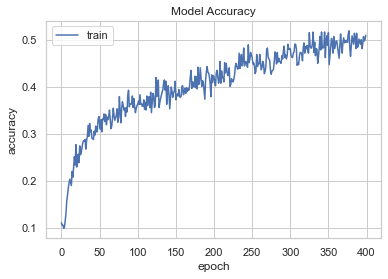

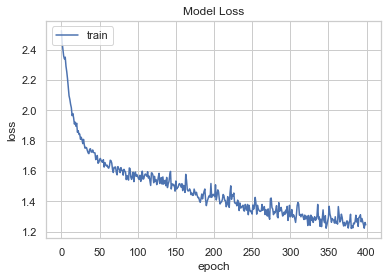

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            592896    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 52.717%


##### Confusion Matrix

184 is the number of test value in kfold_val / train_test_split


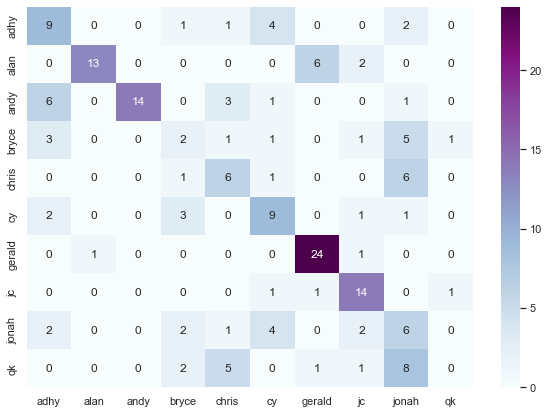

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

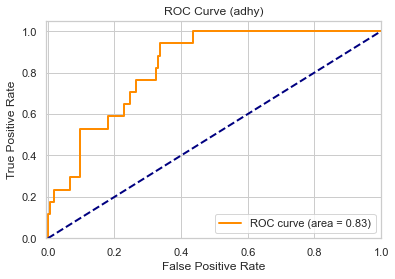

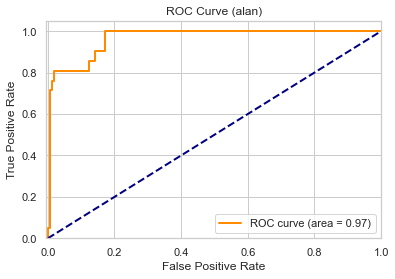

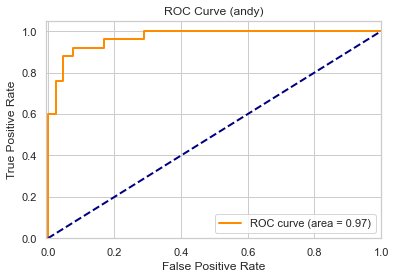

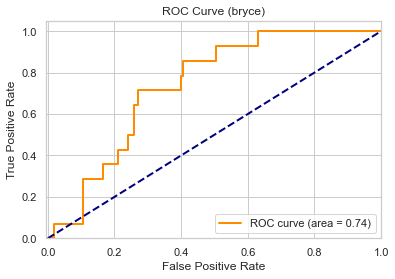

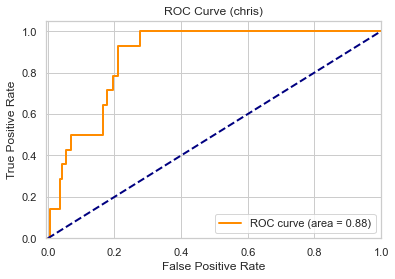

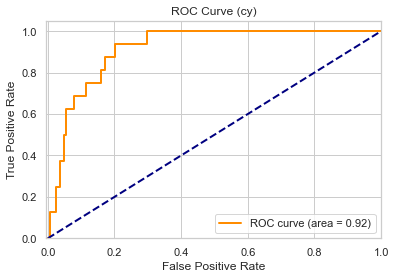

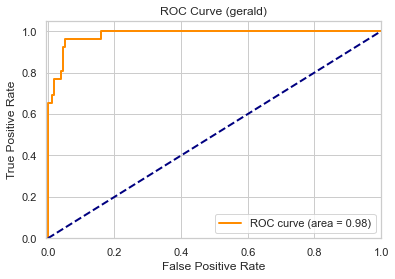

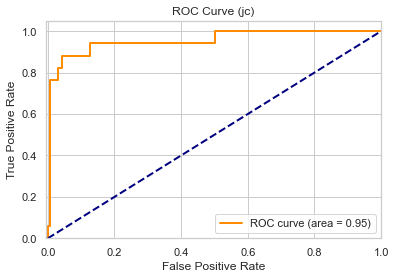

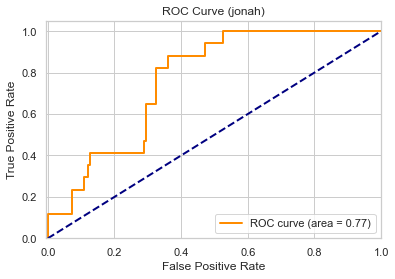

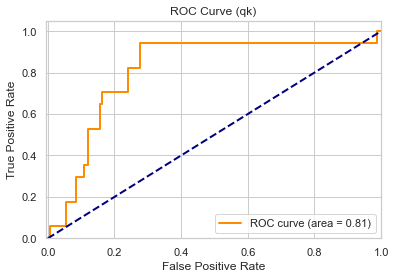

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

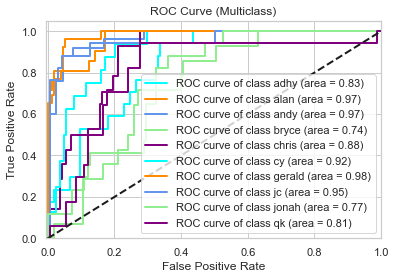

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

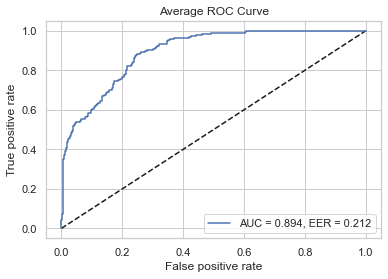

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (920, 322)
Y | Classes  | Dataset Shape: (920, 10)
There are a total of 10 classes.
Epoch 1/400
19/19 [==============================] - 6s 13ms/step - loss: 2.3892 - accuracy: 0.0924
Epoch 2/400
19/19 [==============================] - 0s 12ms/step - loss: 2.3639 - accuracy: 0.0967
Epoch 3/400
19/19 [==============================] - 0s 12ms/step - loss: 2.3494 - accuracy: 0.1065
Epoch 4/400
19/19 [==============================] - 0s 13ms/step - loss: 2.3500 - accuracy: 0.0978
Epoch 5/400
19/19 [==============================] - 0s 13ms/step - loss: 2.3222 - accuracy: 0.1120
Epoch 6/400
19/19 [==============================] - 0s 14ms/step - loss: 2.3054 - accuracy: 0.1304
Epoch 7/400
19/19 [==============================] - 0s 14ms/step - loss: 2.2660 - accuracy: 0.1522
Epoch 8/400
19/19 [==============================] - 0s 13ms/step - loss: 2.

Epoch 80/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5250 - accuracy: 0.3804
Epoch 81/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5345 - accuracy: 0.3620
Epoch 82/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5314 - accuracy: 0.3696
Epoch 83/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5974 - accuracy: 0.3815
Epoch 84/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5267 - accuracy: 0.3630
Epoch 85/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5640 - accuracy: 0.3674
Epoch 86/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5588 - accuracy: 0.3739
Epoch 87/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5430 - accuracy: 0.3533
Epoch 88/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5645 - accuracy: 0.3707
Epoch 89/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5359 - accurac

19/19 [==============================] - 0s 13ms/step - loss: 1.4236 - accuracy: 0.4272
Epoch 161/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5263 - accuracy: 0.3815
Epoch 162/400
19/19 [==============================] - 0s 13ms/step - loss: 1.4950 - accuracy: 0.3880
Epoch 163/400
19/19 [==============================] - 0s 13ms/step - loss: 1.6029 - accuracy: 0.3783
Epoch 164/400
19/19 [==============================] - 0s 13ms/step - loss: 1.6220 - accuracy: 0.3500
Epoch 165/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5234 - accuracy: 0.3913
Epoch 166/400
19/19 [==============================] - 0s 13ms/step - loss: 1.4715 - accuracy: 0.4163
Epoch 167/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5244 - accuracy: 0.3815
Epoch 168/400
19/19 [==============================] - 0s 13ms/step - loss: 1.5038 - accuracy: 0.3978
Epoch 169/400
19/19 [==============================] - 0s 13ms/step - loss: 1.4545 - accuracy: 0

19/19 [==============================] - 0s 13ms/step - loss: 1.3238 - accuracy: 0.4620
Epoch 241/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3423 - accuracy: 0.4783
Epoch 242/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3210 - accuracy: 0.4543
Epoch 243/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3004 - accuracy: 0.4696
Epoch 244/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3400 - accuracy: 0.4630
Epoch 245/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3084 - accuracy: 0.4826
Epoch 246/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3239 - accuracy: 0.4761
Epoch 247/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3098 - accuracy: 0.4815
Epoch 248/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3161 - accuracy: 0.4826
Epoch 249/400
19/19 [==============================] - 0s 13ms/step - loss: 1.3398 - accuracy: 0

19/19 [==============================] - 0s 13ms/step - loss: 1.2815 - accuracy: 0.5011
Epoch 321/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2749 - accuracy: 0.4793
Epoch 322/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2765 - accuracy: 0.5022
Epoch 323/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2576 - accuracy: 0.4826
Epoch 324/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2796 - accuracy: 0.4859
Epoch 325/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2970 - accuracy: 0.5185
Epoch 326/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2349 - accuracy: 0.5185
Epoch 327/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2742 - accuracy: 0.5076
Epoch 328/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2542 - accuracy: 0.5174
Epoch 329/400
19/19 [==============================] - 0s 13ms/step - loss: 1.2515 - accuracy: 0

19/19 [==============================] - 0s 14ms/step - loss: 1.2186 - accuracy: 0.5163


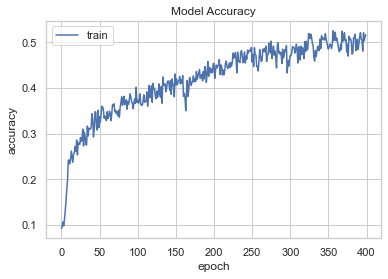

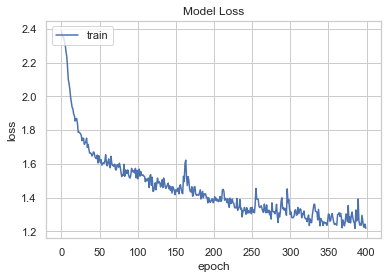

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING FOR IR
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
METHOD = "IR" # identical_random
# METHOD = "DR" # different_random

DATASET_DIR_NAME = "dataset\set02\\01_original"
ACTUAL_DATASET_NAME = "test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set02\\01_original"
RESULT_NAME = "result_" + "set02_01_original_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9
0,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.222830,0.169076,-0.100031,...,0.000018,3.003560e-04,0.015400,0.006169,0.004238,0.017331,1.367618,1.506191,1.468137,1.606710
1,adhy,4,yale zonks,0.069259,-0.015698,0.053560,0.084381,0.153640,0.100079,0.031206,...,0.000478,3.870000e-09,0.022083,0.043876,0.021856,0.000062,0.802144,0.871402,0.871176,0.940435
2,adhy,5,handy iron,0.084898,-0.015655,0.069243,0.115984,0.200882,0.131639,-0.015518,...,0.003094,5.096550e-04,0.011010,0.022040,0.055626,0.022576,0.904103,0.989002,0.988245,1.073144
3,adhy,6,inbred gem,0.100523,0.116285,0.216808,0.216809,0.317332,0.100524,0.100347,...,0.018903,1.890288e-02,0.093657,0.093656,0.137488,0.137488,1.119189,1.219711,1.203950,1.304473
4,adhy,3,taw kungfu,0.146900,-0.031359,0.115541,0.185035,0.331935,0.216394,-0.115934,...,0.014350,4.991602e-03,0.081778,0.032639,0.119791,0.070651,1.087014,1.233914,1.171835,1.318736


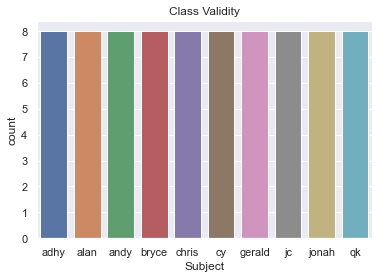

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

ir_result = "Accuracy of the Model for IR dataset is: " + str(match_header)
print(ir_result)

Accuracy of the Model for IR dataset is: 40/80 (50.0%)


# LIVE TESTING FOR DR
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [32]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [33]:
# METHOD = "IR" # identical_random
METHOD = "DR" # different_random

ACTUAL_DATASET_NAME = "test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set02\\01_original"
RESULT_NAME = "result_" + "set02_01_original_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,T2-RF|1+2,T2-NG|1+2,T2-D|2,T2-I|2+3,T2-PF|2+3,T2-RF|2+3,T2-NG|2+3,T2-D|3,T2-I|3+4,T2-PF|3+4,T2-RF|3+4,T2-NG|3+4,T2-D|4,T2-I|4+5,T2-PF|4+5,T2-RF|4+5,T2-NG|4+5,T2-D|5,T2-I|5+6,T2-PF|5+6,T2-RF|5+6,T2-NG|5+6,T2-D|6,T2-I|6+7,T2-PF|6+7,T2-RF|6+7,T2-NG|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-NG|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-NG|8+9,T2-D|9,T2-D|S,T2-I|S,T2-PF|S,T2-RF|S,T2-NG|S,T2-D|M,T2-I|M,T2-PF|M,T2-RF|M,T2-DT-M,T2-D|VAR,T2-I|VAR,T2-PF|VAR,T2-RF|VAR,T2-DT-VAR,T2-D|SD,T2-I|SD,T2-PF|SD,T2-RF|SD,T2-NG|SD,T3-I|0+2,T3-PF|0+2,T3-RF|0+2,T3-NG|0+2,T3-I|1+3,T3-PF|1+3,T3-RF|1+3,T3-NG|1+3,T3-I|2+4,T3-PF|2+4,T3-RF|2+4,T3-NG|2+4,T3-I|3+5,T3-PF|3+5,T3-RF|3+5,T3-NG|3+5,T3-I|4+6,T3-PF|4+6,T3-RF|4+6,T3-NG|4+6,T3-I|5+7,T3-PF|5+7,T3-RF|5+7,T3-NG|5+7,T3-I|6+8,T3-PF|6+8,T3-RF|6+8,T3-NG|6+8,T3-I|7+9,T3-PF|7+9,T3-RF|7+9,T3-NG|7+9,T3-I|S,T3-PF|S,T3-RF|S,T3-NG|S,T3-I|M,T3-PF|M,T3-RF|M,T3-NG|M,T3-I|VAR,T3-PF|VAR,T3-RF|VAR,T3-NG|VAR,T3-I|SD,T3-PF|SD,T3-RF|SD,T3-NG|SD,T4-I|0+3,T4-PF|0+3,T4-RF|0+3,T4-NG|0+3,T4-I|1+4,T4-PF|1+4,T4-RF|1+4,T4-NG|1+4,T4-I|2+5,T4-PF|2+5,T4-RF|2+5,T4-NG|2+5,T4-I|3+6,T4-PF|3+6,T4-RF|3+6,T4-NG|3+6,T4-I|4+7,T4-PF|4+7,T4-RF|4+7,T4-NG|4+7,T4-I|5+8,T4-PF|5+8,T4-RF|5+8,T4-NG|5+8,T4-I|6+9,T4-PF|6+9,T4-RF|6+9,T4-NG|6+9,T4-I|S,T4-PF|S,T4-RF|S,T4-NG|S,T4-I|M,T4-PF|M,T4-RF|M,T4-NG|M,T4-I|VAR,T4-PF|VAR,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4,T5-I|1+5,T5-PF|1+5,T5-RF|1+5,T5-NG|1+5,T5-I|2+6,T5-PF|2+6,T5-RF|2+6,T5-NG|2+6,T5-I|3+7,T5-PF|3+7,T5-RF|3+7,T5-NG|3+7,T5-I|4+8,T5-PF|4+8,T5-RF|4+8,T5-NG|4+8,T5-I|5+9,T5-PF|5+9,T5-RF|5+9,T5-NG|5+9,T5-I|S,T5-PF|S,T5-RF|S,T5-NG|S,T5-I|M,T5-PF|M,T5-RF|M,T5-NG|M,T5-I|VAR,T5-PF|VAR,T5-RF|VAR,T5-NG|VAR,T5-I|SD,T5-PF|SD,T5-RF|SD,T5-NG|SD,T6-I|0+5,T6-PF|0+5,T6-RF|0+5,T6-NG|0+5,T6-I|1+6,T6-PF|1+6,T6-RF|1+6,T6-NG|1+6,T6-I|2+7,T6-PF|2+7,T6-RF|2+7,T6-NG|2+7,T6-I|3+8,T6-PF|3+8,T6-RF|3+8,T6-NG|3+8,T6-I|4+9,T6-PF|4+9,T6-RF|4+9,T6-NG|4+9,T6-I|S,T6-PF|S,T6-RF|S,T6-NG|S,T6-I|M,T6-PF|M,T6-RF|M,T6-NG|M,T6-I|VAR,T6-PF|VAR,T6-RF|VAR,T6-NG|VAR,T6-I|SD,T6-PF|SD,T6-RF|SD,T6-NG|SD,T7-I|0+6,T7-PF|0+6,T7-RF|0+6,T7-NG|0+6,T7-I|1+7,T7-PF|1+7,T7-RF|1+7,T7-NG|1+7,T7-I|2+8,T7-PF|2+8,T7-RF|2+8,T7-NG|2+8,T7-I|3+9,T7-PF|3+9,T7-RF|3+9,T7-NG|3+9,T7-I|S,T7-PF|S,T7-RF|S,T7-NG|S,T7-I|M,T7-PF|M,T7-RF|M,T7-NG|M,T7-I|VAR,T7-PF|VAR,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7,T8-I|1+8,T8-PF|1+8,T8-RF|1+8,T8-NG|1+8,T8-I|2+9,T8-PF|2+9,T8-RF|2+9,T8-NG|2+9,T8-I|S,T8-PF|S,T8-RF|S,T8-NG|S,T8-I|M,T8-PF|M,T8-RF|M,T8-NG|M,T8-I|VAR,T8-PF|VAR,T8-RF|VAR,T8-NG|VAR,T8-I|SD,T8-PF|SD,T8-RF|SD,T8-NG|SD,T9-I|0+8,T9-PF|0+8,T9-RF|0+8,T9-NG|0+8,T9-I|1+9,T9-PF|1+9,T9-RF|1+9,T9-NG|1+9,T9-I|S,T9-PF|S,T9-RF|S,T9-NG|S,T9-I|M,T9-PF|M,T9-RF|M,T9-NG|M,T9-I|VAR,T9-PF|VAR,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9
0,adhy,3,yup doodad,0.138363,0.194245,0.332608,0.363479,0.501841,0.169233,-0.084397,0.084837,0.116071,0.285304,0.200467,-0.015717,0.184750,0.122536,0.323003,0.138253,0.031293,0.169546,0.116290,0.254543,0.084997,0.031187,0.116184,0.100498,0.185495,0.069311,0.031251,0.100562,0.147211,0.216522,0.115960,0.068703,0.184663,0.184861,0.300821,0.116158,0.031137,0.147295,0.153954,0.270112,0.122817,-0.053428,0.069389,0.100364,0.223181,0.153792,1.309352,0.234274,1.389833,1.405263,2.560822,0.130935,0.026030,0.154426,0.156140,0.284536,0.001483,0.006309,0.006287,0.006804,0.008534,0.038513,0.079432,0.079294,0.082484,0.092381,0.279082,0.417445,0.479549,0.617912,0.100353,0.269587,0.238607,0.407840,0.153829,0.354296,0.238826,0.439293,0.147477,0.285730,0.216788,0.355041,0.131749,0.216746,0.247709,0.332706,0.215914,0.285224,0.332072,0.401383,0.215998,0.331958,0.338815,0.454775,0.100526,0.216684,0.254318,0.370476,1.344927,2.377670,2.346683,3.379426,0.168116,0.297209,0.293335,0.422428,0.004001,0.004703,0.007668,0.007927,0.063250,0.0685

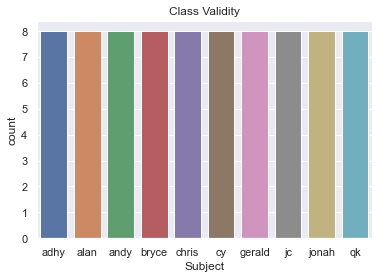

In [34]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [35]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [36]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

dr_result = "Accuracy of the Model for DR dataset: " + str(match_header)
print(dr_result)

Accuracy of the Model for DR dataset: 38/80 (47.5%)


#### RESULT

In [37]:
print(ir_result)
print(dr_result)

Accuracy of the Model for IR dataset is: 40/80 (50.0%)
Accuracy of the Model for DR dataset: 38/80 (47.5%)


In [38]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:18:40
